# 硬件求解器 vs 软件求解器性能对比

对比TinyMPC硬件求解器和tinympcref.py软件求解器在相同N和频率配置下的性能

In [2]:
# set the working directory
import os
os.chdir("/home/xilinx/jupyter_notebooks/zhenyu/tinympc_ip_gen/")

import numpy as np
import matplotlib.pyplot as plt
import time
import sys
import os

# 导入必要的模块
from dynamics import LinearizedQuadcopterDynamics, CrazyflieParams, NoiseModel
from tinympcref import tinympcref as tinympc  # 软件求解器

# 导入硬件求解器
sys.path.append('driver')
from tinympc_hw import tinympc_hw  # 硬件求解器

print("所有模块导入成功")

所有模块导入成功


## 1. 系统配置

In [3]:
# MPC配置参数（硬件和软件使用相同配置）
N = 5  # 预测域
control_freq = 100.0  # 控制频率 Hz
dt = 1.0 / control_freq
nx = 12  # 状态维度
nu = 4   # 控制维度

# 仿真参数
sim_duration = 10.0  # 仿真时间
sim_steps = int(sim_duration * control_freq)

# 求解器参数
max_iter = 100
check_termination = 10

print(f"配置参数:")
print(f"  预测域 N: {N}")
print(f"  控制频率: {control_freq} Hz")
print(f"  状态维度 nx: {nx}")
print(f"  控制维度 nu: {nu}")
print(f"  最大迭代: {max_iter}")
print(f"  仿真步数: {sim_steps}")

配置参数:
  预测域 N: 5
  控制频率: 100.0 Hz
  状态维度 nx: 12
  控制维度 nu: 4
  最大迭代: 100
  仿真步数: 1000


## 2. 初始化动力学模型

In [4]:
# 初始化动力学模型
params = CrazyflieParams()
noise_model = NoiseModel()
dynamics = LinearizedQuadcopterDynamics(params, noise_model)

# 生成系统矩阵
A, B = dynamics.generate_system_matrices(control_freq)
Q, R = dynamics.generate_cost_matrices()
constraints = dynamics.generate_constraints()

print("系统矩阵生成完成")
print(f"A shape: {A.shape}")
print(f"B shape: {B.shape}")
print(f"Q shape: {Q.shape}")
print(f"R shape: {R.shape}")

系统矩阵生成完成
A shape: (12, 12)
B shape: (12, 4)
Q shape: (12, 12)
R shape: (4, 4)


## 3. 生成测试轨迹

参考轨迹生成完成: X_ref shape = (12, 1000)


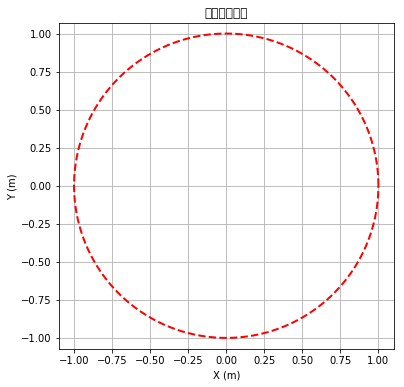

In [5]:
# 生成圆形参考轨迹用于测试
radius = 1.0
center = [0, 0, 1.0]
omega = 2 * np.pi / sim_duration

t = np.linspace(0, sim_duration, sim_steps)
X_ref = np.zeros((nx, sim_steps))

# 位置
X_ref[0, :] = center[0] + radius * np.cos(omega * t)
X_ref[1, :] = center[1] + radius * np.sin(omega * t)
X_ref[2, :] = center[2]

# 速度
X_ref[6, :] = -radius * omega * np.sin(omega * t)
X_ref[7, :] = radius * omega * np.cos(omega * t)
X_ref[8, :] = 0

U_ref = np.zeros((nu, sim_steps-1))

print(f"参考轨迹生成完成: X_ref shape = {X_ref.shape}")

# 可视化参考轨迹
plt.figure(figsize=(6, 6))
plt.plot(X_ref[0, :], X_ref[1, :], 'r--', linewidth=2)
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('测试参考轨迹')
plt.grid(True)
plt.axis('equal')
plt.show()

## 4. 初始化求解器

In [6]:
# 初始化软件求解器
print("初始化软件求解器...")
sw_solver = tinympc()
sw_solver.setup(A, B, Q, R, N, x_min=constraints['x_min'], x_max=constraints['x_max'],
                u_min=constraints['u_min'], u_max=constraints['u_max'],
                max_iter=max_iter, check_termination=check_termination, verbose=0)
print("软件求解器初始化完成")

# 初始化硬件求解器
bitstream_path = "/home/xilinx/jupyter_notebooks/zhenyu/tinympc_ip_gen/bitstream/tinympcproj_N5_100Hz_float.bit"
hw_solver = tinympc_hw(bitstream_path=bitstream_path)
hw_solver.set_clock_frequency(100)
hw_solver.setup(max_iter=max_iter, check_termination=check_termination, verbose=0)
print("硬件求解器初始化完成")

hw_available = True

初始化软件求解器...
软件求解器初始化完成
Loading overlay from: /home/xilinx/jupyter_notebooks/zhenyu/tinympc_ip_gen/bitstream/tinympcproj_N5_100Hz_float.bit
Setting FCLK0 frequency from 99.999 MHz to 250 MHz
Clock frequency set to 249.9975 MHz
Found TinyMPC IP core: tinympc_solver_0
Allocated 164 float32 memory buffer at 0x60230000
IP core initialized with memory address: 0x0000000060230000
  Lower 32 bits: 0x60230000
  Upper 32 bits: 0x00000000
TinyMPC driver initialized successfully
Changing FCLK0 frequency from 249.9975 MHz to 100 MHz
Clock frequency updated to 99.999 MHz
硬件求解器初始化完成


## 5. 单步求解性能对比

In [7]:
# 准备测试数据
test_x0 = X_ref[:, 0] + np.random.normal(0, 0.05, nx)
test_xref = X_ref[:, :N].T  # (N, nx)
test_uref = U_ref[:, :N-1].T  # (N-1, nu)

print("\n=== 单步求解性能测试 ===")
print(f"初始状态: x0 = [{test_x0[0]:.3f}, {test_x0[1]:.3f}, {test_x0[2]:.3f}, ...]")

# 测试软件求解器
print("\n软件求解器测试:")
sw_solver.set_x0(test_x0)
sw_solver.set_x_ref(test_xref)
sw_solver.set_u_ref(test_uref)

sw_start = time.time()
sw_solver.solve()
sw_time = (time.time() - sw_start) * 1000  # 转换为ms

sw_u = sw_solver.u[0, :] if sw_solver.solved else np.zeros(nu)
print(f"  求解时间: {sw_time:.3f} ms")
print(f"  迭代次数: {sw_solver.iter}")
print(f"  收敛状态: {'已收敛' if sw_solver.solved else '未收敛'}")
print(f"  控制输出: u = [{sw_u[0]:.3f}, {sw_u[1]:.3f}, {sw_u[2]:.3f}, {sw_u[3]:.3f}]")

# 测试硬件求解器
if hw_available:
    print("\n硬件求解器测试:")
    hw_solver.set_x0(test_x0)
    hw_solver.set_x_ref(test_xref)
    hw_solver.set_u_ref(test_uref)
    
    hw_start = time.time()
    hw_success = hw_solver.solve(timeout=1.0)
    hw_time = (time.time() - hw_start) * 1000  # 转换为ms
    
    hw_u = hw_solver.u[0, :] if hw_success else np.zeros(nu)
    print(f"  求解时间: {hw_time:.3f} ms")
    print(f"  收敛状态: {'已收敛' if hw_solver.solved else '未收敛'}")
    print(f"  控制输出: u = [{hw_u[0]:.3f}, {hw_u[1]:.3f}, {hw_u[2]:.3f}, {hw_u[3]:.3f}]")
    
    # 计算差异
    control_diff = np.linalg.norm(sw_u - hw_u)
    speedup = sw_time / hw_time if hw_time > 0 else 0
    
    print(f"\n性能对比:")
    print(f"  加速比: {speedup:.2f}x")
    print(f"  控制输出差异: {control_diff:.6f}")
else:
    print("\n硬件求解器不可用，跳过硬件测试")


=== 单步求解性能测试 ===
初始状态: x0 = [0.956, 0.012, 1.051, ...]

软件求解器测试:
  求解时间: 12.886 ms
  迭代次数: 10
  收敛状态: 已收敛
  控制输出: u = [-0.027, -0.032, -0.026, -0.031]

硬件求解器测试:
Parameters written: max_iter=100, check_termination_iter=10
Before start - Control: 0x00000004 (ready: False, idle: True)
IP started...
IP completed after 26 polls
Hardware execution completed in 0.0022 seconds
  求解时间: 2.351 ms
  收敛状态: 已收敛
  控制输出: u = [-0.027, -0.032, -0.026, -0.031]

性能对比:
  加速比: 5.48x
  控制输出差异: 0.000004


## 6. 完整轨迹追踪对比

In [8]:
def run_tracking_simulation(solver, solver_type, X_ref, U_ref, A, B, constraints, sim_steps, N):
    """运行轨迹追踪仿真"""
    x_current = X_ref[:, 0] + np.random.normal(0, 0.05, nx)
    x_history = [x_current.copy()]
    u_history = []
    solve_times = []
    
    print(f"\n运行{solver_type}求解器仿真...")
    
    for step in range(sim_steps - 1):
        # 准备参考轨迹
        X_ref_horizon = np.zeros((nx, N))
        U_ref_horizon = np.zeros((nu, N-1))
        
        for i in range(N):
            ref_idx = min(step + i, sim_steps - 1)
            X_ref_horizon[:, i] = X_ref[:, ref_idx]
        for i in range(N-1):
            ref_idx = min(step + i, sim_steps - 2)
            U_ref_horizon[:, i] = U_ref[:, ref_idx]
        
        # 设置求解器
        solver.set_x0(x_current)
        solver.set_x_ref(X_ref_horizon.T)
        solver.set_u_ref(U_ref_horizon.T)
        
        # 求解
        solve_start = time.time()
        if solver_type == "硬件":
            success = solver.solve(timeout=0.5)
            u_control = solver.u[0, :] if success and solver.solved else np.zeros(nu)
        else:
            solver.solve()
            u_control = solver.u[0, :] if solver.solved else np.zeros(nu)
        
        solve_time = (time.time() - solve_start) * 1000
        solve_times.append(solve_time)
        
        # 系统仿真
        x_next = A @ x_current + B @ u_control
        x_next = np.clip(x_next, constraints['x_min'], constraints['x_max'])
        
        x_current = x_next
        x_history.append(x_current.copy())
        u_history.append(u_control.copy())
        
        # 进度显示
        if (step + 1) % 100 == 0:
            print(f"  步骤 {step+1}/{sim_steps-1}")
    
    return np.array(x_history), np.array(u_history), np.array(solve_times)

# 运行软件求解器仿真
sw_x_history, sw_u_history, sw_solve_times = run_tracking_simulation(
    sw_solver, "软件", X_ref, U_ref, A, B, constraints, sim_steps, N
)

# 运行硬件求解器仿真（如果可用）
if hw_available:
    hw_x_history, hw_u_history, hw_solve_times = run_tracking_simulation(
        hw_solver, "硬件", X_ref, U_ref, A, B, constraints, sim_steps, N
    )
else:
    hw_x_history = None
    hw_u_history = None
    hw_solve_times = None

print("\n仿真完成！")


运行软件求解器仿真...
  步骤 100/999
  步骤 200/999
  步骤 300/999
  步骤 400/999
  步骤 500/999
  步骤 600/999
  步骤 700/999
  步骤 800/999
  步骤 900/999

运行硬件求解器仿真...
Parameters written: max_iter=100, check_termination_iter=10
Before start - Control: 0x00000004 (ready: False, idle: True)
IP started...
IP completed after 26 polls
Hardware execution completed in 0.0025 seconds
Parameters written: max_iter=100, check_termination_iter=10
Before start - Control: 0x00000004 (ready: False, idle: True)
IP started...
IP completed after 26 polls
Hardware execution completed in 0.0017 seconds
Parameters written: max_iter=100, check_termination_iter=10
Before start - Control: 0x00000004 (ready: False, idle: True)
IP started...
IP completed after 26 polls
Hardware execution completed in 0.0021 seconds
Parameters written: max_iter=100, check_termination_iter=10
Before start - Control: 0x00000004 (ready: False, idle: True)
IP started...
IP completed after 26 polls
Hardware execution completed in 0.0019 seconds
Parameters 

## 7. 结果可视化对比

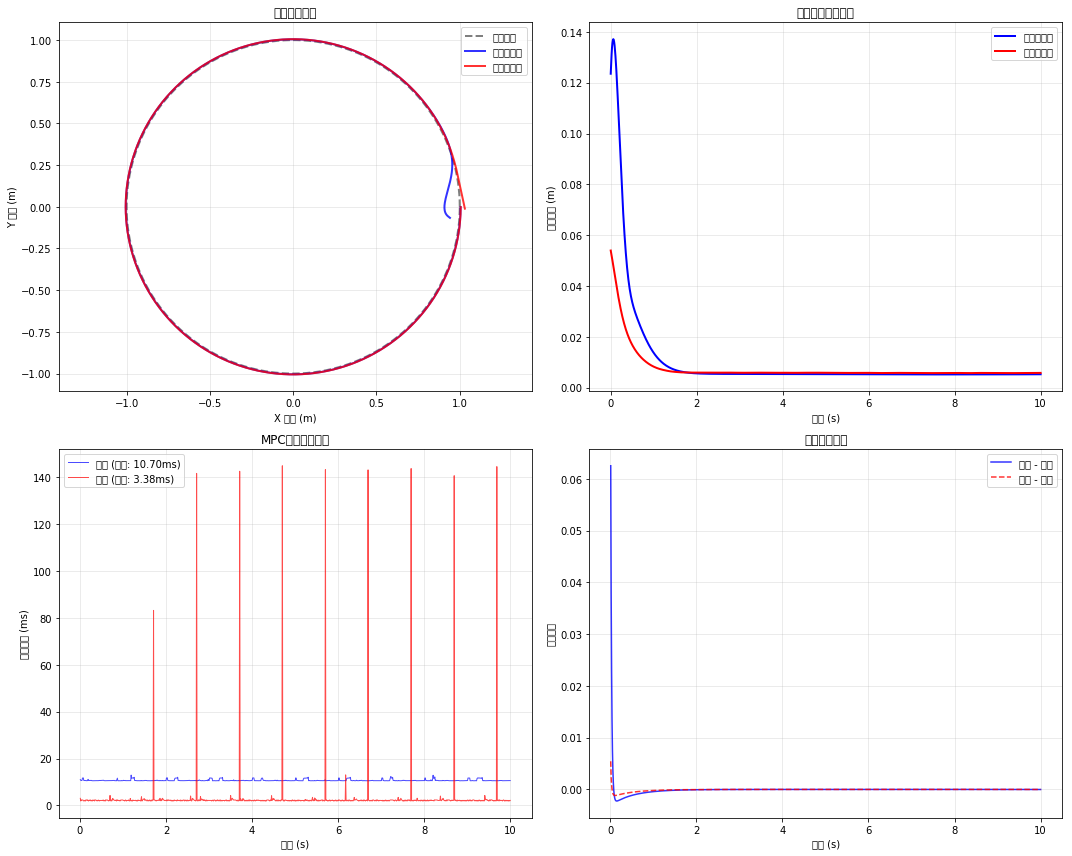

In [9]:
# 创建对比图
if hw_available:
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
else:
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

time_vec = np.linspace(0, sim_duration, len(sw_x_history))

# 1. 轨迹对比
ax1.plot(X_ref[0, :], X_ref[1, :], 'k--', linewidth=2, label='参考轨迹', alpha=0.5)
ax1.plot(sw_x_history[:, 0], sw_x_history[:, 1], 'b-', linewidth=2, label='软件求解器', alpha=0.8)
if hw_available:
    ax1.plot(hw_x_history[:, 0], hw_x_history[:, 1], 'r-', linewidth=2, label='硬件求解器', alpha=0.8)
ax1.set_xlabel('X 位置 (m)')
ax1.set_ylabel('Y 位置 (m)')
ax1.set_title('轨迹追踪对比')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.axis('equal')

# 2. 位置误差对比
sw_errors = []
hw_errors = []
for i in range(len(sw_x_history)):
    ref_idx = min(i, X_ref.shape[1]-1)
    sw_error = np.linalg.norm(sw_x_history[i, :3] - X_ref[:3, ref_idx])
    sw_errors.append(sw_error)
    if hw_available:
        hw_error = np.linalg.norm(hw_x_history[i, :3] - X_ref[:3, ref_idx])
        hw_errors.append(hw_error)

ax2.plot(time_vec, sw_errors, 'b-', linewidth=2, label='软件求解器')
if hw_available:
    ax2.plot(time_vec, hw_errors, 'r-', linewidth=2, label='硬件求解器')
ax2.set_xlabel('时间 (s)')
ax2.set_ylabel('位置误差 (m)')
ax2.set_title('位置跟踪误差对比')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. 求解时间对比
time_vec_control = time_vec[1:len(sw_solve_times)+1]
ax3.plot(time_vec_control, sw_solve_times, 'b-', linewidth=1, label=f'软件 (平均: {np.mean(sw_solve_times):.2f}ms)', alpha=0.7)
if hw_available:
    ax3.plot(time_vec_control[:len(hw_solve_times)], hw_solve_times, 'r-', linewidth=1, label=f'硬件 (平均: {np.mean(hw_solve_times):.2f}ms)', alpha=0.7)
ax3.set_xlabel('时间 (s)')
ax3.set_ylabel('求解时间 (ms)')
ax3.set_title('MPC求解时间对比')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. 控制输入对比（第一个控制量）
ax4.plot(time_vec_control[:len(sw_u_history)], sw_u_history[:, 0], 'b-', linewidth=1.5, label='软件 - 推力', alpha=0.8)
if hw_available:
    ax4.plot(time_vec_control[:len(hw_u_history)], hw_u_history[:, 0], 'r--', linewidth=1.5, label='硬件 - 推力', alpha=0.8)
ax4.set_xlabel('时间 (s)')
ax4.set_ylabel('推力控制')
ax4.set_title('控制输入对比')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. 性能统计分析

In [ ]:
print("="*60)
print("            性能对比统计分析")
print("="*60)

# 软件求解器统计
print("\n软件求解器 (tinympcref.py):")
print(f"  平均位置误差: {np.mean(sw_errors):.5f} m")
print(f"  最大位置误差: {np.max(sw_errors):.5f} m")
print(f"  最终位置误差: {sw_errors[-1]:.5f} m")
print(f"  误差标准差: {np.std(sw_errors):.5f} m")
print(f"  平均求解时间: {np.mean(sw_solve_times):.3f} ms")
print(f"  最大求解时间: {np.max(sw_solve_times):.3f} ms")
print(f"  最小求解时间: {np.min(sw_solve_times):.3f} ms")
print(f"  求解时间标准差: {np.std(sw_solve_times):.3f} ms")

if hw_available:
    print("\n硬件求解器 (tinympc_hw):")
    print(f"  平均位置误差: {np.mean(hw_errors):.5f} m")
    print(f"  最大位置误差: {np.max(hw_errors):.5f} m")
    print(f"  最终位置误差: {hw_errors[-1]:.5f} m")
    print(f"  误差标准差: {np.std(hw_errors):.5f} m")
    print(f"  平均求解时间: {np.mean(hw_solve_times):.3f} ms")
    print(f"  最大求解时间: {np.max(hw_solve_times):.3f} ms")
    print(f"  最小求解时间: {np.min(hw_solve_times):.3f} ms")
    print(f"  求解时间标准差: {np.std(hw_solve_times):.3f} ms")
    
    print("\n对比分析:")
    print("="*40)
    
    # 性能对比
    speedup = np.mean(sw_solve_times) / np.mean(hw_solve_times)
    error_diff = abs(np.mean(sw_errors) - np.mean(hw_errors))
    error_ratio = np.mean(hw_errors) / np.mean(sw_errors) if np.mean(sw_errors) > 0 else 0
    
    print(f"  平均加速比: {speedup:.2f}x")
    print(f"  误差差异: {error_diff:.6f} m")
    print(f"  误差比率: {error_ratio:.3f}")
    
    # 控制输出一致性
    control_diff = np.mean(np.linalg.norm(sw_u_history - hw_u_history[:len(sw_u_history)], axis=1))
    print(f"  平均控制差异: {control_diff:.6f}")
    
    # 实时性分析
    sw_realtime = (1000.0/control_freq) / np.mean(sw_solve_times)  # 实时因子
    hw_realtime = (1000.0/control_freq) / np.mean(hw_solve_times)
    
    print(f"\n实时性能:")
    print(f"  控制周期: {1000.0/control_freq:.1f} ms")
    print(f"  软件实时因子: {sw_realtime:.2f}x {('(满足实时)' if sw_realtime > 1 else '(不满足实时)')}")
    print(f"  硬件实时因子: {hw_realtime:.2f}x {('(满足实时)' if hw_realtime > 1 else '(不满足实时)')}")
    
    # 稳定性分析
    sw_solve_variance = np.var(sw_solve_times)
    hw_solve_variance = np.var(hw_solve_times)
    
    print(f"\n求解稳定性:")
    print(f"  软件求解时间方差: {sw_solve_variance:.3f} ms²")
    print(f"  硬件求解时间方差: {hw_solve_variance:.3f} ms²")
    print(f"  硬件稳定性提升: {sw_solve_variance/hw_solve_variance:.2f}x")

print("\n="*60)
print("配置信息:")
print(f"  MPC预测域 N: {N}")
print(f"  控制频率: {control_freq} Hz")
print(f"  最大迭代: {max_iter}")
print(f"  终止检查: {check_termination}")
print(f"  仿真时长: {sim_duration} s")
print(f"  仿真步数: {sim_steps}")

## 9. 求解时间分布分析

In [ ]:
if hw_available:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # 直方图对比
    bins = np.linspace(0, max(np.max(sw_solve_times), np.max(hw_solve_times)), 30)
    
    ax1.hist(sw_solve_times, bins=bins, alpha=0.6, label='软件求解器', color='blue', edgecolor='black')
    ax1.hist(hw_solve_times, bins=bins, alpha=0.6, label='硬件求解器', color='red', edgecolor='black')
    ax1.axvline(np.mean(sw_solve_times), color='blue', linestyle='--', linewidth=2, label=f'软件平均: {np.mean(sw_solve_times):.2f}ms')
    ax1.axvline(np.mean(hw_solve_times), color='red', linestyle='--', linewidth=2, label=f'硬件平均: {np.mean(hw_solve_times):.2f}ms')
    ax1.set_xlabel('求解时间 (ms)')
    ax1.set_ylabel('频次')
    ax1.set_title('求解时间分布')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 箱线图对比
    ax2.boxplot([sw_solve_times, hw_solve_times], labels=['软件', '硬件'], 
                showmeans=True, meanline=True)
    ax2.set_ylabel('求解时间 (ms)')
    ax2.set_title('求解时间箱线图')
    ax2.grid(True, alpha=0.3)
    
    # 添加实时线
    realtime_limit = 1000.0 / control_freq
    ax2.axhline(y=realtime_limit, color='green', linestyle=':', linewidth=2, 
               label=f'实时限制: {realtime_limit:.1f}ms')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    # 百分位数分析
    print("\n求解时间百分位数分析:")
    percentiles = [50, 75, 90, 95, 99]
    print(f"{'百分位':<10} {'软件 (ms)':<15} {'硬件 (ms)':<15} {'加速比':<10}")
    print("-" * 50)
    for p in percentiles:
        sw_p = np.percentile(sw_solve_times, p)
        hw_p = np.percentile(hw_solve_times, p)
        speedup_p = sw_p / hw_p if hw_p > 0 else 0
        print(f"{p}%{'':<8} {sw_p:<15.3f} {hw_p:<15.3f} {speedup_p:<10.2f}x")

else:
    print("硬件求解器不可用，无法进行分布分析")

## 10. 结论总结

In [ ]:
print("\n" + "="*60)
print("                    对比测试总结")
print("="*60)

if hw_available:
    # 计算关键指标
    avg_speedup = np.mean(sw_solve_times) / np.mean(hw_solve_times)
    max_speedup = np.max(sw_solve_times) / np.max(hw_solve_times)
    error_similarity = 1.0 - abs(np.mean(sw_errors) - np.mean(hw_errors)) / np.mean(sw_errors)
    
    print("\n关键发现:")
    print(f"1. 硬件加速: 平均提速 {avg_speedup:.2f}倍，最大提速 {max_speedup:.2f}倍")
    print(f"2. 精度一致性: 轨迹跟踪误差相似度 {error_similarity*100:.1f}%")
    print(f"3. 实时性能: 硬件求解器{'满足' if np.mean(hw_solve_times) < 1000.0/control_freq else '不满足'}实时要求")
    print(f"4. 稳定性: 硬件求解时间方差降低 {(1 - np.var(hw_solve_times)/np.var(sw_solve_times))*100:.1f}%")
    
    print("\n优势分析:")
    if avg_speedup > 5:
        print("✓ 硬件求解器显著提升计算速度")
    elif avg_speedup > 2:
        print("✓ 硬件求解器有效提升计算速度")
    else:
        print("○ 硬件求解器速度提升有限")
    
    if error_similarity > 0.95:
        print("✓ 硬件与软件求解精度高度一致")
    elif error_similarity > 0.90:
        print("✓ 硬件与软件求解精度基本一致")
    else:
        print("△ 硬件与软件求解精度存在差异")
    
    if np.std(hw_solve_times) < np.std(sw_solve_times):
        print("✓ 硬件求解器时间稳定性更好")
    else:
        print("○ 软件求解器时间稳定性更好")
        
else:
    print("\n注意: 硬件求解器未能成功初始化")
    print("仅完成了软件求解器的测试")
    print(f"\n软件求解器性能:")
    print(f"  - 平均求解时间: {np.mean(sw_solve_times):.3f} ms")
    print(f"  - 平均跟踪误差: {np.mean(sw_errors):.5f} m")
    print(f"  - 实时性: {'满足' if np.mean(sw_solve_times) < 1000.0/control_freq else '不满足'}")

print("\n" + "="*60)

## 总结

本notebook对比了TinyMPC硬件求解器和tinympcref.py软件求解器在相同配置下的性能:

1. **配置一致性**: 使用相同的N、控制频率、系统矩阵和约束
2. **性能对比**: 求解时间、跟踪精度、控制输出
3. **统计分析**: 平均值、方差、百分位数、实时性
4. **可视化对比**: 轨迹、误差、求解时间、控制输入

通过这个对比，可以清楚地看到硬件加速带来的性能提升和两种求解器的一致性。